# Importing Data and Modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import json
from io import StringIO
pd.options.display.max_columns = 100

In [2]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import ARResults

In [3]:
import azure
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient
import os
import re
import yaml

In [4]:
# As a class to preserve state
class AzureBlobStorageManager:
    def __init__(self, connection_str: str, container_name: str):
        self.blob_service_client = BlobServiceClient.from_connection_string(connection_str)
        self.container_client = self.blob_service_client.get_container_client(container_name)

    def download_blob(self, blob_name: str):
        """Download a blob from the container """
        # Create a blob client
        blob_client = self.container_client.get_blob_client(blob_name)
        try:
            # Download blob
            blob_data = blob_client.download_blob().readall()
            df = pd.read_csv(StringIO(blob_data.decode('utf-8')))
            print(f"Blob {blob_name} downloaded successfully.")
            return df
        except Exception as e:  # Do something with this exception block (e.g. add logging)
            print(f"An error occurred: {str(e)}")
            logger.error(f"An error occurred: {str(e)}")
            return 0

In [5]:
# Testing class and method

connection_string =  # Azure container/Access Key/Under Key1, Connection String.
container_name =  # The name comes from Containers. 

az_blob_manager = AzureBlobStorageManager(connection_str=connection_string,
                                          container_name=container_name)

all_df = az_blob_manager.download_blob('district_data.csv')

Blob district_data.csv downloaded successfully.


In [6]:
all_df

,district,year,month,system_cost,system_count,rebate,capacity,date,rebate_eff(W/$),tech_cost($/W)
0,3,2021,10,245282.0,6,31142.5,66855.0,1/10/21,2.15,3.67
1,5,2021,10,45000.0,1,6000.0,13870.0,1/10/21,2.31,3.24
2,6,2021,10,164089.0,7,34915.5,56685.0,1/10/21,1.62,2.89
3,8,2021,10,252638.0,7,35815.0,57710.0,1/10/21,1.61,4.38
4,10,2021,10,336187.0,9,50820.0,88170.0,1/10/21,1.73,3.81
...,...,...,...,...,...,...,...,...,...,...
305,16,2023,10,28337.0,1,861.0,5740.0,1/10/23,6.67,4.94
306,17,2023,10,43514.0,1,6000.0,9200.0,1/10/23,1.53,4.73
307,18,2023,10,70744.0,1,6000.0,15795.0,1/10/23,2.63,4.48
308,20,2023,10,268250.0,9,52624.0,78035.0,1/10/23,1.48,3.44


In [7]:
allowed_districts = all_df['district'].value_counts() > 24

In [8]:
allowed_list = allowed_districts[allowed_districts].index.tolist()

In [9]:
all_df = all_df[all_df['district'].isin(allowed_list)]

In [10]:
all_df['district'].value_counts()

district
3     25
6     25
8     25
10    25
13    25
17    25
20    25
Name: count, dtype: int64

# Accepting Input

In [11]:
while True:
    try:
        # Prompt the user for input
        dist_num = int(input("Enter a district number: "))
        
        # Check if the input is in the predefined list
        if dist_num in allowed_list:
            print("Valid input received.")
            break  # Exit the loop if the input is valid
        else:
            # Inform the user that the input is not valid and prompt for another input
            print(f"Invalid input. Please enter a number from the list: {allowed_list}")
    except ValueError:
        # Handle the case where the input cannot be converted to int
        print("Invalid input. Please enter a valid integer.")

Enter a district number:  13


Valid input received.


In [12]:
dist_df = all_df[all_df['district']==dist_num]

In [13]:
dist_df.index = pd.to_datetime(dist_df['date'], format='%d/%m/%y')

In [14]:
dist_df['system_count'].index.freq = 'MS'

# Rebate Efficiency Metric

In [15]:
metric_name = 'tech_cost($/W)'

<Axes: xlabel='date'>

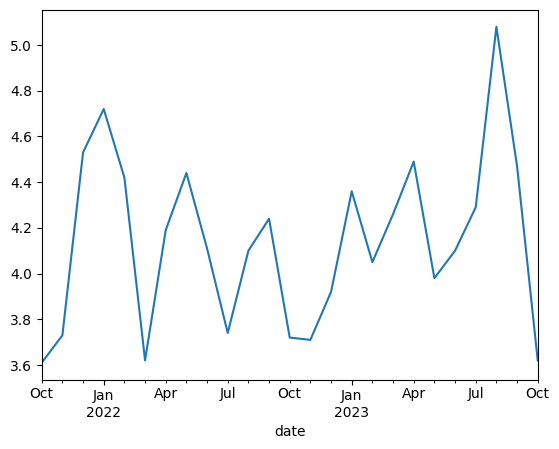

In [16]:
dist_df[metric_name].plot()

#### Determining stationarity:

##### Augmented Dickey-Fuller Test:

In [17]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(dist_df[metric_name])
p_value = result[1]

if p_value <= 0.05:
    print(f"The data is likely stationary. (p={round(p_value,2)})")
else:
    print(f"The data is likely non-stationary. (p={round(p_value,2)})")

The data is likely non-stationary. (p=0.27)


##### Visual approach:

In [18]:
from pandas.plotting import lag_plot

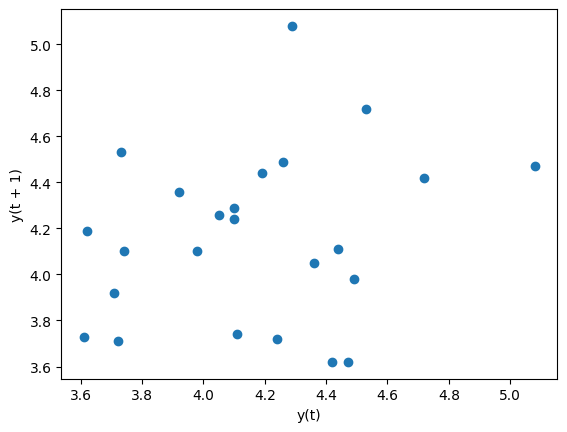

In [19]:
lag_plot(dist_df[metric_name]);

In [20]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [21]:
len(dist_df[metric_name])

25

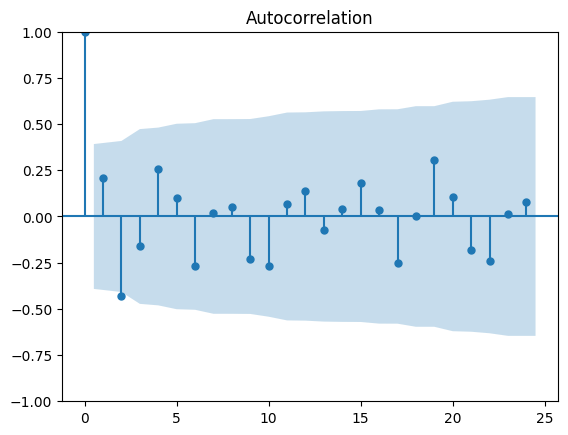

In [22]:
plot_acf(dist_df[metric_name],lags=24);

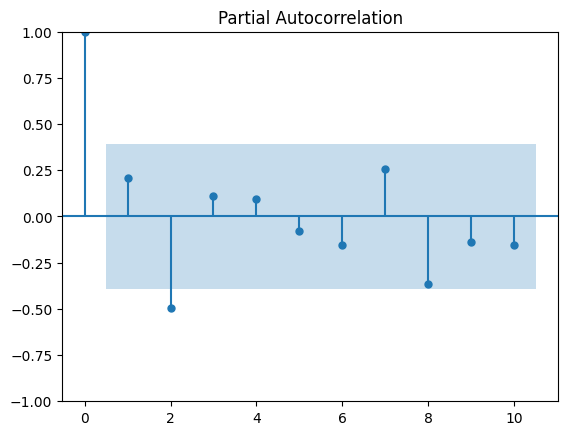

In [23]:
plot_pacf(dist_df[metric_name],lags=10);

**Note:** pacf plot works best with a data that is already stationary.

#### Determining data characteristics / outliers:

/Users/kamran/anaconda3/envs/pygris/lib/python3.10/site-packages/seaborn/categorical.py:486: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if np.isscalar(data[0]):


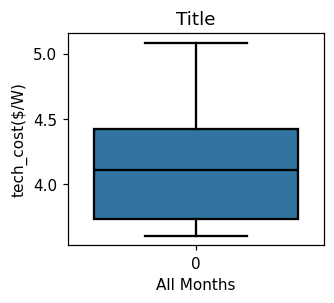

In [24]:
plt.figure(figsize=(3.0, 2.5), dpi=110)
ax = sns.boxplot(data=dist_df[metric_name], 
                 boxprops=dict(edgecolor='black'), flierprops=dict(markeredgecolor='black'),
                 whiskerprops=dict(color='black'), medianprops=dict(color='black'),
                 capprops=dict(color='black'))  # Set the color of whisker heads

ax.set_xlabel('All Months')
ax.set_ylabel(metric_name)
ax.set_title('Title')

# Set the text color for labels and title to black
ax.xaxis.label.set_color('black')
ax.yaxis.label.set_color('black')
ax.title.set_color('black')

# Customize tick label colors
ax.tick_params(axis='x', colors='black')
ax.tick_params(axis='y', colors='black')

# Draw a black frame around the plot area
ax.spines['top'].set_color('black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')

In [25]:
data = dist_df[metric_name]

# Calculate the 25th and 75th percentiles (Q1 and Q3)
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define the lower and upper bounds for identifying outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify potential outliers
outliers = data[(data < lower_bound) | (data > upper_bound)]

# 'outliers' now contains the potential outlier values

In [26]:
outliers

Series([], Freq: MS, Name: tech_cost($/W), dtype: float64)

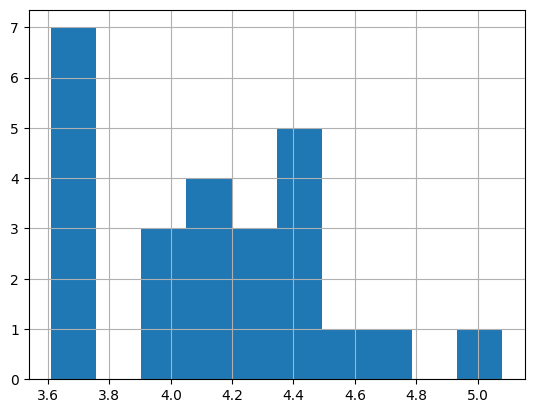

In [27]:
dist_df[metric_name].hist(bins=10);

In [28]:
dist_df[metric_name].describe()

count    25.000000
mean      4.140000
std       0.380077
min       3.610000
25%       3.740000
50%       4.110000
75%       4.420000
max       5.080000
Name: tech_cost($/W), dtype: float64

In [29]:
from scipy.stats import zscore

z_scores = zscore(dist_df[metric_name])

In [30]:
z_scores

date
2021-10-01   -1.423210
2021-11-01   -1.100974
2021-12-01    1.047268
2022-01-01    1.557475
2022-02-01    0.751884
2022-03-01   -1.396357
2022-04-01    0.134265
2022-05-01    0.805591
2022-06-01   -0.080559
2022-07-01   -1.074121
2022-08-01   -0.107412
2022-09-01    0.268530
2022-10-01   -1.127827
2022-11-01   -1.154680
2022-12-01   -0.590766
2023-01-01    0.590766
2023-02-01   -0.241677
2023-03-01    0.322236
2023-04-01    0.939856
2023-05-01   -0.429648
2023-06-01   -0.107412
2023-07-01    0.402795
2023-08-01    2.524184
2023-09-01    0.886150
2023-10-01   -1.396357
Freq: MS, Name: tech_cost($/W), dtype: float64

In [31]:
# Define a threshold for considering outliers (e.g., ±2 standard deviations)
threshold = 2

# Identify potential outliers
outliers = dist_df[abs(z_scores) > threshold]

In [32]:
outliers

,district,year,month,system_cost,system_count,rebate,capacity,date,rebate_eff(W/$),tech_cost($/W)
date,,,,,,,,,,
2023-08-01,13,2023,8,585904.0,15,63538.5,115335.0,1/8/23,1.82,5.08


In [33]:
z_scores[abs(z_scores) > threshold]

date
2023-08-01    2.524184
Freq: MS, Name: tech_cost($/W), dtype: float64

<Axes: xlabel='date'>

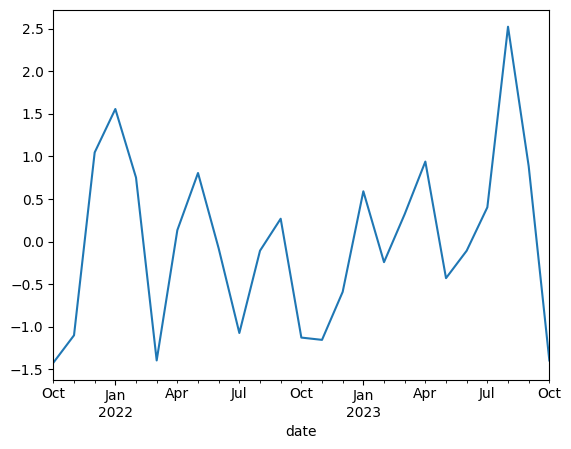

In [34]:
z_scores.plot()

In [35]:
from statsmodels.tsa.seasonal import seasonal_decompose

<Figure size 1000x300 with 0 Axes>

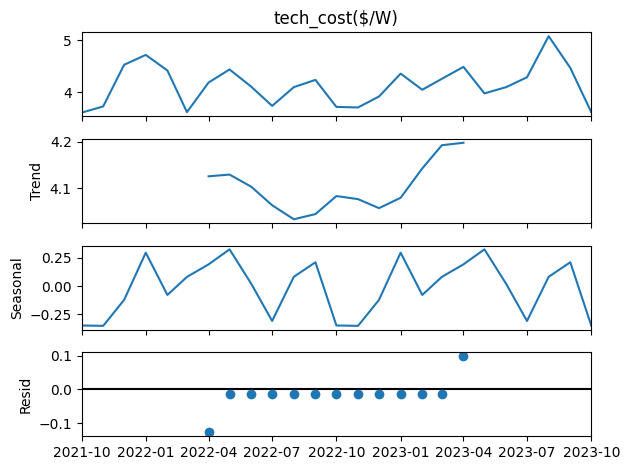

In [36]:
result = seasonal_decompose(dist_df[metric_name], model='additive')
plt.figure(figsize=(10, 3))
result.plot();

#### Train-Test split:

In [37]:
from sklearn.model_selection import train_test_split

train_size = 0.85
train, test = train_test_split(dist_df[metric_name], train_size=train_size, shuffle=False)

<Axes: xlabel='date'>

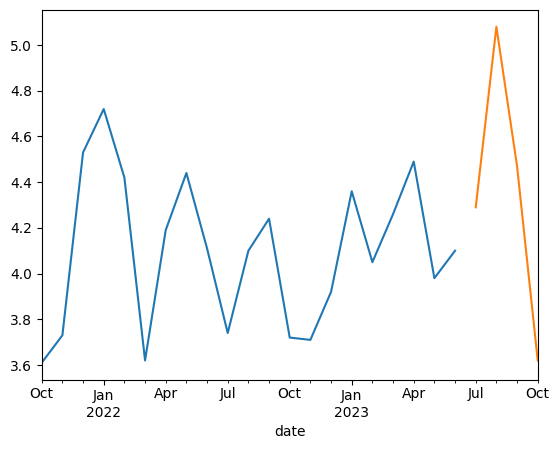

In [38]:
train.plot()
test.plot()

#### Model selection and fitting:

In [39]:
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.ar_model import ARResults

# Fit an AR(1) model (you can experiment with different orders)
ar1_model = AutoReg(train,lags=1)
ar1_model = ar1_model.fit()

# View model summary and select the best order based on AIC or BIC
print(ar1_model.summary())

                            AutoReg Model Results                             
Dep. Variable:         tech_cost($/W)   No. Observations:                   21
Model:                     AutoReg(1)   Log Likelihood                  -4.330
Method:               Conditional MLE   S.D. of innovations              0.300
Date:                Fri, 29 Mar 2024   AIC                             14.660
Time:                        14:01:12   BIC                             17.647
Sample:                    11-01-2021   HQIC                            15.243
                         - 06-01-2023                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 3.2897      0.844      3.900      0.000       1.636       4.943
tech_cost($/W).L1     0.2030      0.205      0.989      0.323      -0.199       0.605
                        

#### Model evaluation:

In [40]:
# Make predictions on the testing data
ar1_predictions = ar1_model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

# Calculate Mean Absolute Error (MAE) or Mean Squared Error (MSE)
from sklearn.metrics import mean_absolute_error, mean_squared_error

ar1_mae = mean_absolute_error(test, ar1_predictions)
ar1_mse = mean_squared_error(test, ar1_predictions)
ar1_rmse = np.sqrt(ar1_mse)

print(f'AR(1)_MAE: {ar1_mae}')
print(f'AR(1)_MSE: {ar1_mse}')
print(f'AR(1)_RMSE: {ar1_rmse}')

AR(1)_MAE: 0.4928695336215514
AR(1)_MSE: 0.3280541127232286
AR(1)_RMSE: 0.5727600830393373


In [41]:
test.describe()

count    4.000000
mean     4.365000
std      0.600805
min      3.620000
25%      4.122500
50%      4.380000
75%      4.622500
max      5.080000
Name: tech_cost($/W), dtype: float64

<Axes: xlabel='date'>

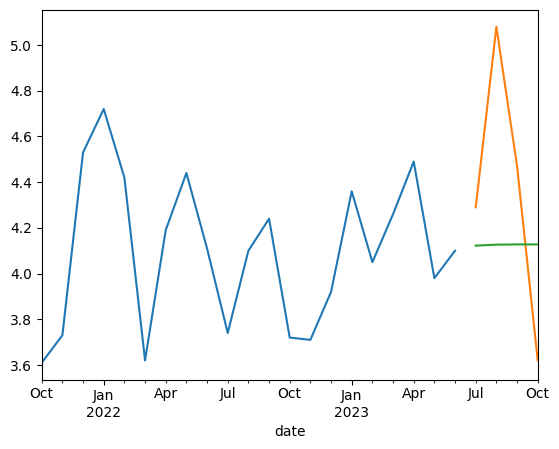

In [42]:
train.plot()
test.plot()
ar1_predictions.plot()

#### Model refinement (trying AR(2) and AR(3)):

In [43]:
ar2_model = AutoReg(train, lags=[1, 2])
ar2_model = ar2_model.fit()

ar3_model = AutoReg(train, lags=[1, 2, 3])
ar3_model = ar3_model.fit()

ar2_predictions = ar2_model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)
ar3_predictions = ar3_model.predict(start=len(train), end=len(train) + len(test) - 1, dynamic=False)

ar2_mae = mean_absolute_error(test, ar2_predictions)
ar2_mse = mean_squared_error(test, ar2_predictions)
ar2_rmse = np.sqrt(ar2_mse)

ar3_mae = mean_absolute_error(test, ar3_predictions)
ar3_mse = mean_squared_error(test, ar3_predictions)
ar3_rmse = np.sqrt(ar3_mse)

print(f'AR(2)_MAE: {ar2_mae}')
print(f'AR(2)_MSE: {ar2_mse}')
print(f'AR(2)_RMSE: {ar2_rmse}')
print('\n')
print(f'AR(3)_MAE: {ar3_mae}')
print(f'AR(3)_MSE: {ar3_mse}')
print(f'AR(3)_RMSE: {ar3_rmse}')

AR(2)_MAE: 0.4656995733312037
AR(2)_MSE: 0.3056984142360451
AR(2)_RMSE: 0.5529000038307516


AR(3)_MAE: 0.46777292736132425
AR(3)_MSE: 0.3128016660605468
AR(3)_RMSE: 0.5592867476174872


In [44]:
metrics_dict = {
    'Model': ['AR(1)', 'AR(2)', 'AR(3)'],
    'MAE': [ar1_mae, ar2_mae, ar3_mae],
    'MSE': [ar1_mse, ar2_mse, ar3_mse],
    'RMSE': [ar1_rmse, ar2_rmse, ar3_rmse]
}

# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics_dict)

# Display the DataFrame
print(metrics_df)


   Model       MAE       MSE      RMSE
0  AR(1)  0.492870  0.328054  0.572760
1  AR(2)  0.465700  0.305698  0.552900
2  AR(3)  0.467773  0.312802  0.559287


In [45]:
from tabulate import tabulate

# Create a list of lists with your data
table_data = [
    ["AR(1)", ar1_mae, ar1_mse, ar1_rmse],
    ["AR(2)", ar2_mae, ar2_mse, ar2_rmse],
    ["AR(3)", ar3_mae, ar3_mse, ar3_rmse]
]

# Define the headers for your table
headers = ["Model", "MAE", "MSE", "RMSE"]

# Use the tabulate function to create a formatted table
table = tabulate(table_data, headers, tablefmt="pretty")

# Print or display the table
print(table)

+-------+---------------------+--------------------+--------------------+
| Model |         MAE         |        MSE         |        RMSE        |
+-------+---------------------+--------------------+--------------------+
| AR(1) | 0.4928695336215514  | 0.3280541127232286 | 0.5727600830393373 |
| AR(2) | 0.4656995733312037  | 0.3056984142360451 | 0.5529000038307516 |
| AR(3) | 0.46777292736132425 | 0.3128016660605468 | 0.5592867476174872 |
+-------+---------------------+--------------------+--------------------+


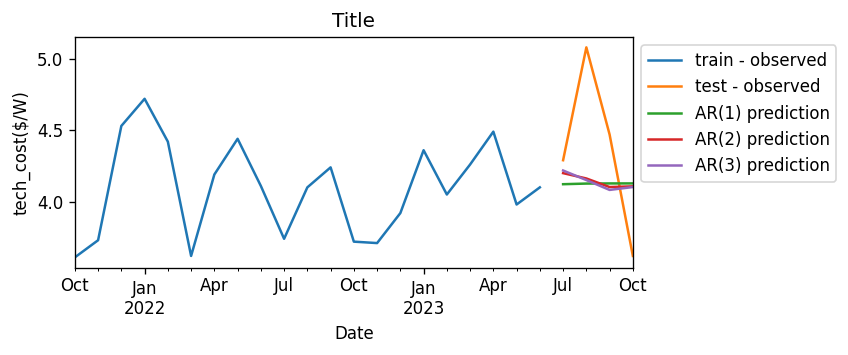

In [46]:
plt.figure(figsize=(6,2.5),dpi=120)
train.plot(label='train - observed')
test.plot(label='test - observed')
ar1_predictions.plot(label='AR(1) prediction')
ar2_predictions.plot(label='AR(2) prediction')
ar3_predictions.plot(label='AR(3) prediction')
plt.legend(loc=0,bbox_to_anchor=(1,1))
plt.title('Title')
plt.xlabel('Date')
plt.ylabel(metric_name);

#### Model diagnostics:

##### Finding and plotting residuals:

In [47]:
# Check the residuals
ar1_residuals = test - ar1_predictions

In [48]:
ar1_residuals

date
2023-07-01    0.167891
2023-08-01    0.953402
2023-09-01    0.342491
2023-10-01   -0.507694
Freq: MS, dtype: float64

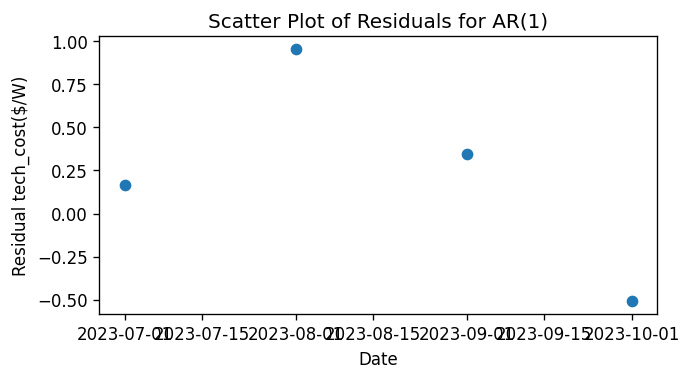

In [49]:
plt.figure(figsize=(6,3),dpi=120)
plt.scatter(y=ar1_residuals.values,x=ar1_residuals.index)
plt.title('Scatter Plot of Residuals for AR(1)')
plt.xlabel('Date')
plt.ylabel(f'Residual {metric_name}');

##### Finding any patterns in ACF and PACF plot

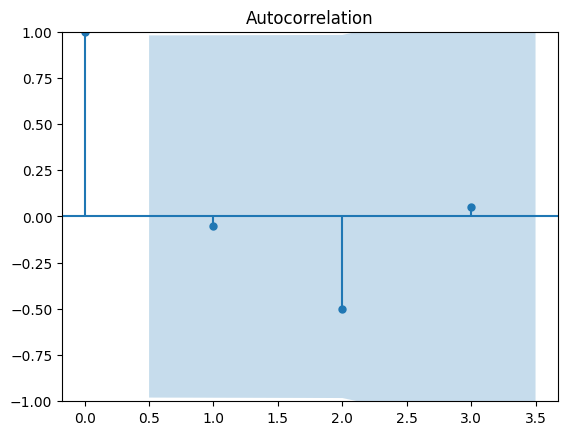

In [50]:
plot_acf(ar1_residuals);

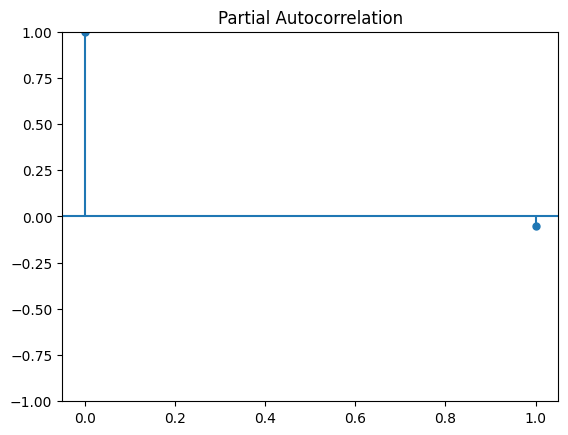

In [51]:
plot_pacf(ar1_residuals,lags=1);

##### Normality tests:

Shapiro-Wilk test:

The null hypothesis is that the residuals are normally distributed. 

In [52]:
from scipy import stats

shapiro_test_statistic, shapiro_p_value = stats.shapiro(ar1_residuals)

if shapiro_p_value < 0.05:
    print("Residuals are not normally distributed (reject null hypothesis).")
else:
    print("Residuals are normally distributed (fail to reject null hypothesis).")

Residuals are normally distributed (fail to reject null hypothesis).


This means that there is not enough evidence to suggest that the residuals significantly deviate from a normal distribution. In other words, the test indicates that the residuals follow a normal distribution, and you can consider this assumption as valid for your time series model. Normally distributed residuals imply that the model's errors or deviations from predictions have the expected characteristics of a bell-shaped, symmetric distribution. It suggests that the model adequately captures the variation in the data.

#### Forecasting:

In [53]:
ar1_forecast = AutoReg(dist_df[metric_name],lags=1).fit()

In [54]:
# Forecast future values
forecast_steps = 3
ar1_forecast = ar1_model.predict(start=len(dist_df), end=len(dist_df) + forecast_steps - 1, dynamic=False)
print(ar1_forecast)

2023-11-01    4.127732
2023-12-01    4.127739
2024-01-01    4.127741
Freq: MS, dtype: float64


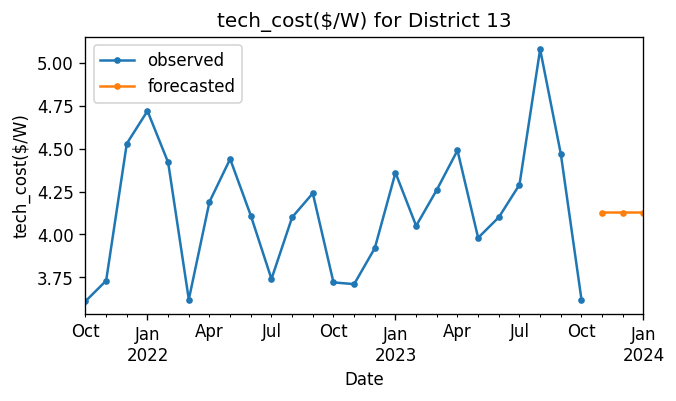

In [55]:
plt.figure(figsize=(6,3),dpi=120)
dist_df[metric_name].plot(label='observed',marker='.')
ar1_forecast.plot(marker='.',label='forecasted')
plt.legend()
plt.title(f'{metric_name} for District {dist_num}')
plt.xlabel('Date')
plt.ylabel(f'{metric_name}');

# System Count Metric (SCM)

In [56]:
scm_ar1_model = AutoReg(dist_df['system_count'],lags=1).fit()

In [57]:
# Forecast future values
forecast_steps = 3
scm_ar1_forecast = round(scm_ar1_model.predict(start=len(dist_df), end=len(dist_df) + forecast_steps - 1, dynamic=False),0)

In [58]:
scm_pred = pd.DataFrame(scm_ar1_forecast,columns=['system_count'])

In [59]:
print(scm_pred)

            system_count
2023-11-01          16.0
2023-12-01          16.0
2024-01-01          16.0


# Total Rebate Metric (TCM)

In [60]:
trm_ar1_model = AutoReg(dist_df['rebate'],lags=1).fit()

In [61]:
# Forecast future values
forecast_steps = 3
trm_ar1_forecast = round(trm_ar1_model.predict(start=len(dist_df), end=len(dist_df) + forecast_steps - 1, dynamic=False),0)

In [62]:
trm_pred = pd.DataFrame(trm_ar1_forecast,columns=['rebate'])

In [63]:
print(trm_pred)

             rebate
2023-11-01  86412.0
2023-12-01  90203.0
2024-01-01  92289.0


# Technology Cost Metric (TCM)

In [64]:
tcm_ar1_model = AutoReg(dist_df['tech_cost($/W)'],lags=1).fit()

In [65]:
# Forecast future values
forecast_steps = 3
tcm_ar1_forecast = round(tcm_ar1_model.predict(start=len(dist_df), end=len(dist_df) + forecast_steps - 1, dynamic=False),2)

In [66]:
tcm_pred = pd.DataFrame(tcm_ar1_forecast,columns=['tech_cost($/W)'])

In [67]:
print(tcm_pred)

            tech_cost($/W)
2023-11-01            4.04
2023-12-01            4.14
2024-01-01            4.16


# Rebate Efficiency Metric (REM)

In [68]:
rem_ar1_model = AutoReg(dist_df['rebate_eff(W/$)'],lags=1).fit()

In [69]:
# Forecast future values
forecast_steps = 3
rem_ar1_forecast = round(rem_ar1_model.predict(start=len(dist_df), end=len(dist_df) + forecast_steps - 1, dynamic=False),2)

In [70]:
rem_pred = pd.DataFrame(rem_ar1_forecast,columns=['rebate_eff(W/$)'])

In [71]:
print(rem_pred)

            rebate_eff(W/$)
2023-11-01             1.59
2023-12-01             1.60
2024-01-01             1.60


# Concatenating Results

In [72]:
historic_data = dist_df[['system_count','rebate','tech_cost($/W)','rebate_eff(W/$)']].copy()

In [73]:
prediction_data = merged_df = pd.concat([scm_pred,
                                  trm_pred,
                                  tcm_pred,
                                 rem_pred], axis=1).copy()

In [74]:
historic_data.loc[:, 'IsPrediction'] = 0  # For original rows, the indicator is 0
prediction_data.loc[:, 'IsPrediction'] = 1  # For prediction rows, the indicator is 1

In [75]:
historic_data['rebate'] = historic_data['rebate'].round(2)

In [76]:
final_data = pd.concat([historic_data, prediction_data], axis=0)

In [77]:
final_data

,system_count,rebate,tech_cost($/W),rebate_eff(W/$),IsPrediction
2021-10-01,7.0,32350.00,3.61,1.53,0
2021-11-01,8.0,41227.00,3.73,1.55,0
2021-12-01,2.0,9380.00,4.53,1.43,0
2022-01-01,9.0,42969.00,4.72,1.50,0
2022-02-01,4.0,18881.00,4.42,2.11,0
2022-03-01,3.0,14861.00,3.62,1.43,0
2022-04-01,8.0,41963.00,4.19,1.82,0
2022-05-01,17.0,85939.22,4.44,1.68,0
2022-06-01,3.0,19880.00,4.11,1.37,0
2022-07-01,13.0,85568.00,3.74,1.53,0
